## Two cavity modes coupled to mechanical mode and a qubit

In [92]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from numpy import *
from qutip import *
from IPython.display import Image
from numpy.linalg import *
import multiprocessing  
from multiprocessing import Pool, cpu_count
import scipy.constants as sc
import time
import datetime
import os
from matplotlib import cm
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})
plt.rcParams['axes.linewidth'] = 1.5 #set the value globally
plt.rcParams['figure.dpi'] = 100

We consider a system hybrid system of two cavity modes coupled to a single mechancial mode, and also dispersively coupled a two level system (qubit). In the strong dispersive regime, we must satisfy $$ |\omega_q - \omega_k| \gg G_k,$$

where $\omega_q$ is the qubit frequency and $\omega_k $ is the $k$-th cavity resonant frequency which is coupled to the qubit with a copling strength $G_k$. The Hamiltonian which describes this system will be given by 

$$ \hat{H} = \hat{H}_0 + \hat{H}_\text{int} + \hat{H}_\text{drive}, $$

where the first term $\hat{H}_0$ corresponds to the free Hamiltonian of the system, which will be given by

$$\hat{H}_0 = \omega_r\hat{r}^\dagger\hat{r} + \Delta_a\,\hat{a}^\dagger \hat{a}  + \Delta_b\,\hat{b}^\dagger \hat{b} +  \frac{\omega_q}{2}\sigma_z ,$$

where $\Delta_k = \omega_k - \Omega_k$ is the detuning between the cavity modes and the driving field. The interaction between multiple parts of the system will be described by the second term $H_\text{int}$ which is given by

$$\hat{H}_\text{int} = - g_a\,\hat{a}^\dagger\hat{a}(\hat{r}^\dagger+\hat{r}) - g_b\,\hat{b}^\dagger\hat{b}(\hat{r}^\dagger+\hat{r}) + \left(\frac{{G_a}^2}{\omega_q - \omega_a}\right)\, (\hat{a}^\dagger\hat{a} + 1/2)\sigma_z +  \left(\frac{{G_b}^2}{\omega_q - \omega_b}\right) \, (\hat{b}^\dagger\hat{b}+ 1/2)\,\sigma_z,$$

where we can define the ratio $\chi_k \equiv \frac{{G_k}^2}{\omega_q - \omega_k}$. Finally, the cavities will be driven by an external field described by the last term $H_\text{drive}$ given by

$$\hat{H}_\text{drive} =  E_a \left(\hat{a}^\dagger + \hat{a}\right)  +  E_b \left(\hat{b}^\dagger + \hat{b}\right).$$

### Caso 1: Estado térmico, sem MR

In [337]:
# Dimension
N = 3

##### Cavity A ######

wa = 2 * pi * 2.0 * 1e9

Ohm_a = wa
E_a = 0  

kappa_a = 2 * pi * 100 * 1e3  

T_a = 0.05
w_th_a = (sc.k*T_a)/(sc.hbar)
n_th_a = n_thermal(wa, w_th_a)

###### Cavity B #####

wb = 2 * pi * 2.0 * 1e9

Ohm_b = wb
E_b = 0

kappa_b = 2 * pi * 100 * 1e3

T_b = 0.05
w_th_b = (sc.k*T_b)/(sc.hbar)
n_th_b = n_thermal(wb, w_th_b)


##### Qubit #####

wq = 2 * pi * 3.0 * 1e9

Ga = 2 * pi * 200 * 1e6
Gb = 2 * pi * 100 * 1e6

kappa_q = 2 * pi * 100 * 1e3

T_q = 0.09
w_th_q = (sc.k*T_q)/(sc.hbar)
n_th_q = n_thermal(wq, w_th_q)

##### Mechanical Resonator #####

wr = 2 * pi * 1.0 * 1e9

ga = 0
gb = 0

gamma = 10 * kappa_a  

T_r = 0.01
w_th_r = (sc.k*T_r)/(sc.hbar)
n_th_r = n_thermal(wr, w_th_r)


############################
(n_th_a, n_th_b, n_th_q, n_th_r)


(0.1718539759369543,
 0.1718539759369543,
 0.25305033913702896,
 0.008304373364239451)

In the strong dispersive regime, we must satisfy $$ |\omega_q - \omega_k| \gg G_k,$$

where $\omega_q$ is the qubit frequency and $\omega_k $ is the $k$-th cavity resonant frequency which is coupled to the qubit with a copling strength $G_k$.

In [338]:
delta = abs(wa - wq)

delta/(2*pi*1e6), Ga/(2*pi*1e6)

(999.9999999999998, 200.00000000000003)

In [339]:
delta = abs(wb - wq)

delta/(2*pi*1e6), Gb/(2*pi*1e6)

(999.9999999999998, 100.00000000000001)

In [340]:
chi_a = Ga**2/(wq-wa)
chi_b = Gb**2/(wq-wb)

(chi_a/(2*pi*1e6),chi_b/(2*pi*1e6))

(40.00000000000002, 10.000000000000005)

In [341]:
# Operator definitions
a = tensor(destroy(N), qeye(N), qeye(2), qeye(N))
b = tensor(qeye(N), destroy(N), qeye(2), qeye(N))
r = tensor(qeye(N), qeye(N), qeye(2), destroy(N))
sm = tensor(qeye(N), qeye(N), destroy(2), qeye(N))
sz = tensor(qeye(N), qeye(N), sigmaz(), qeye(N))
sx = tensor(qeye(N), qeye(N), sigmax(), qeye(N))
I = tensor(qeye(N), qeye(N), qeye(2), qeye(N))

Na = a.dag() * a
Nb = b.dag() * b
Nq = sm.dag() * sm
Nr = r.dag() * r
Xa = a.dag() + a
Xb = b.dag() + b
Xq = sm.dag() + sm
Xr = r.dag() + r

In [342]:
Ha = (wa-Ohm_a) * Na
Hb = (wb-Ohm_b) * Nb
Hr = wr * Nr
Hint_a = -ga * Na * Xr
Hint_b = -gb * Nb * Xr
Hdrive_a = E_a * Xa
Hdrive_b = E_b * Xb
Hq = 0.5 * (wq) * sz
#Hqa = Ga * (a * sm.dag() + a.dag() * sm)
#Hqb = Gb * (b * sm.dag() + b.dag() * sm)
Hqa = (Ga**2/(wq-wa)) * Na * sz 
Hqb = (Gb**2/(wq-wb)) * Nb * sz 
        
H = Ha + Hb + Hr + Hint_a + Hint_b + Hdrive_a + Hdrive_b + Hq + Hqa + Hqb

In [343]:
# collapse operators
c_ops = []

# Relaxations, temperature = 0 or >0

# cavity-a relaxation
rate = kappa_a * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(sqrt(rate) * a)
    
# cavity-b relaxation
rate = kappa_b * (1 + n_th_b)
if rate > 0.0:
    c_ops.append(sqrt(rate) * b)
    
# mechanical oscillator relaxation
rate = gamma * (1 + n_th_r)
if rate > 0.0:
    c_ops.append(sqrt(rate) * r)

# qubit dissipation
rate = kappa_q * (1 + n_th_q)
if rate > 0.0:
    c_ops.append(sqrt(rate) * sm)
    
# Excitations, only temperature > 0  

rate = kappa_a * n_th_a
if rate > 0.0:
    c_ops.append(sqrt(rate) * a.dag())

rate = kappa_b * n_th_b
if rate > 0.0:
    c_ops.append(sqrt(rate) * b.dag())

rate = kappa_q * n_th_q
if rate > 0.0:
    c_ops.append(sqrt(rate) * sm.dag())

# mechanical oscillator excitation    
rate = gamma * n_th_r
if rate > 0.0:
    c_ops.append(sqrt(rate) * r.dag())

In [344]:
w_0 = 2 * pi * 2 * 1e9
w_f = 2 * pi * 4 * 1e9

wlist = linspace(w_0,w_f,5000)

slist = spectrum(H,wlist,c_ops,sx,sx)

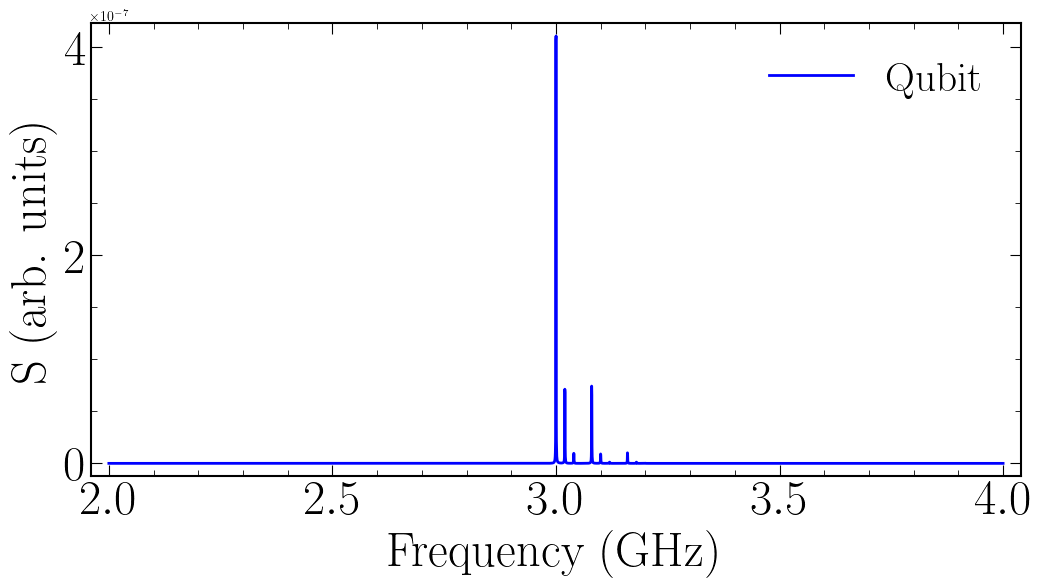

In [345]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot(wlist/(2*pi*1e9), (abs(slist)),'b', label='Qubit', lw=2.0)

axes.set_xlabel(r'Frequency (GHz)', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=0,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

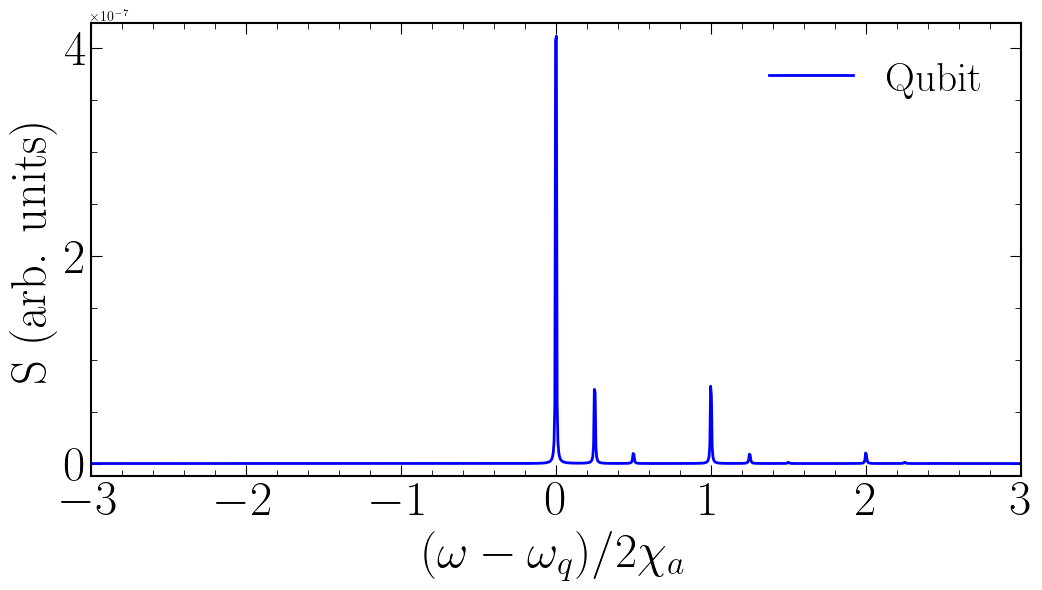

In [347]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist-wq)/(2*chi_a), (abs(slist)),'b', label='Qubit', lw=2.0)

axes.set_xlabel(r'$(\omega - \omega_q)/2\chi_a$', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-3,3)
#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

In [348]:
w_0_2 = 2 * pi * -1 * 1e9
w_f_2 = 2 * pi * 1 * 1e9

wlist2 = linspace(w_0_2,w_f_2,8000)

slist_2 = spectrum(H,wlist2,c_ops,a.dag(),a)

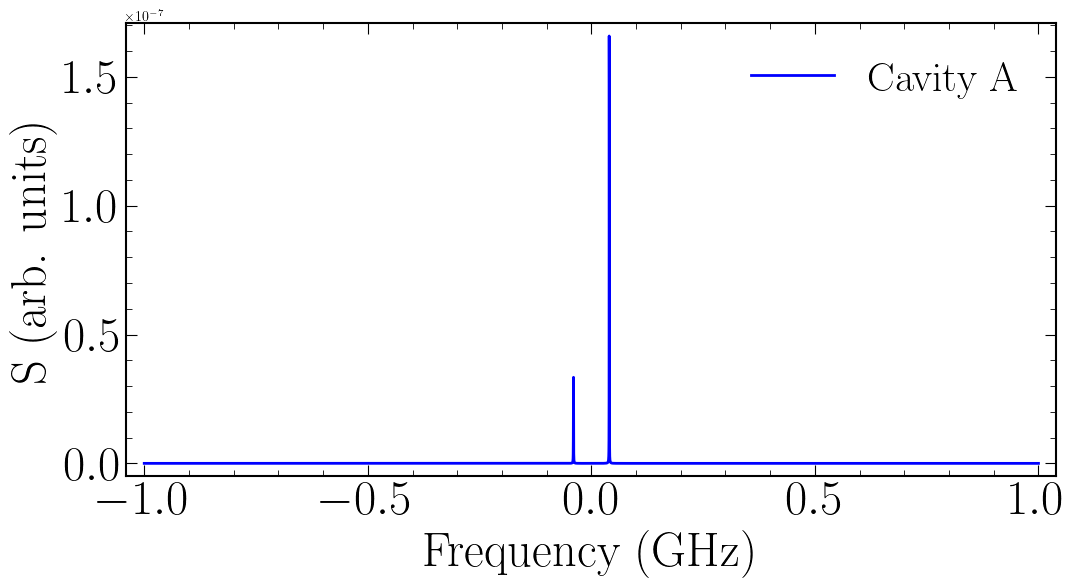

In [349]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist2)/(2*pi*1e9), (abs(slist_2)),'b', label='Cavity A', lw=2.0)

axes.set_xlabel(r'Frequency (GHz)', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

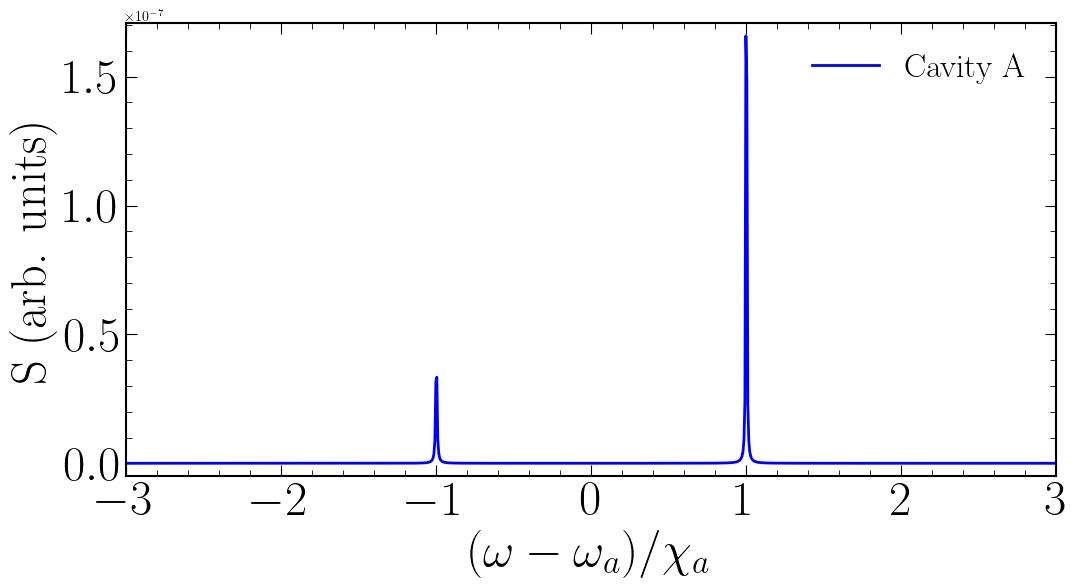

In [350]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist2)/(chi_a), (abs(slist_2)),'b', label='Cavity A', lw=2.0)

axes.set_xlabel(r'$(\omega-\omega_a)/\chi_a$', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-3,3)
#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=24,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

In [275]:
slist_3 = spectrum(H,wlist2,c_ops,b.dag(),b)

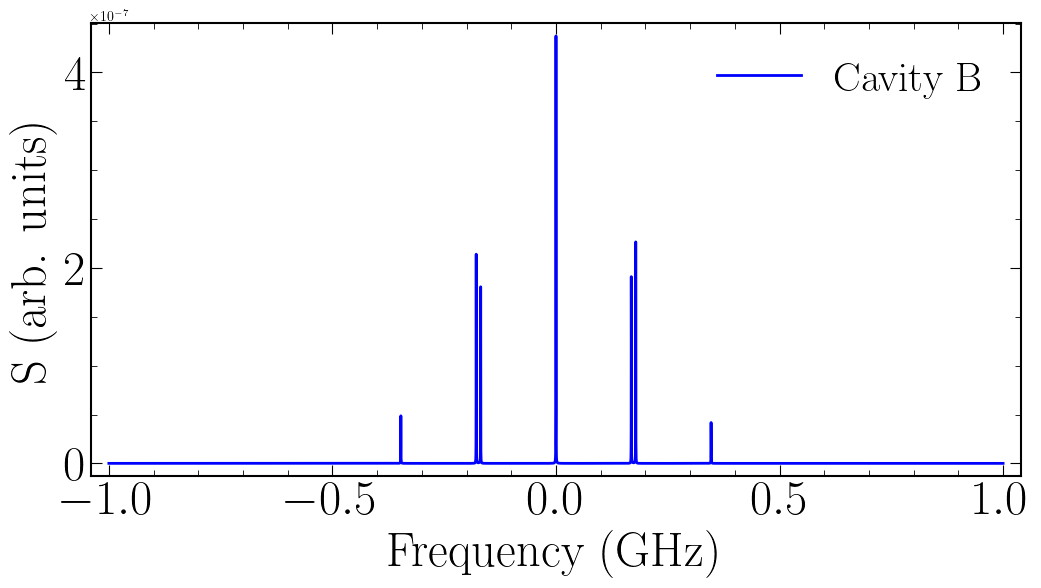

In [351]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist2)/(2*pi*1e9), (abs(slist_3)),'b', label='Cavity B', lw=2.0)

axes.set_xlabel(r'Frequency (GHz)', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

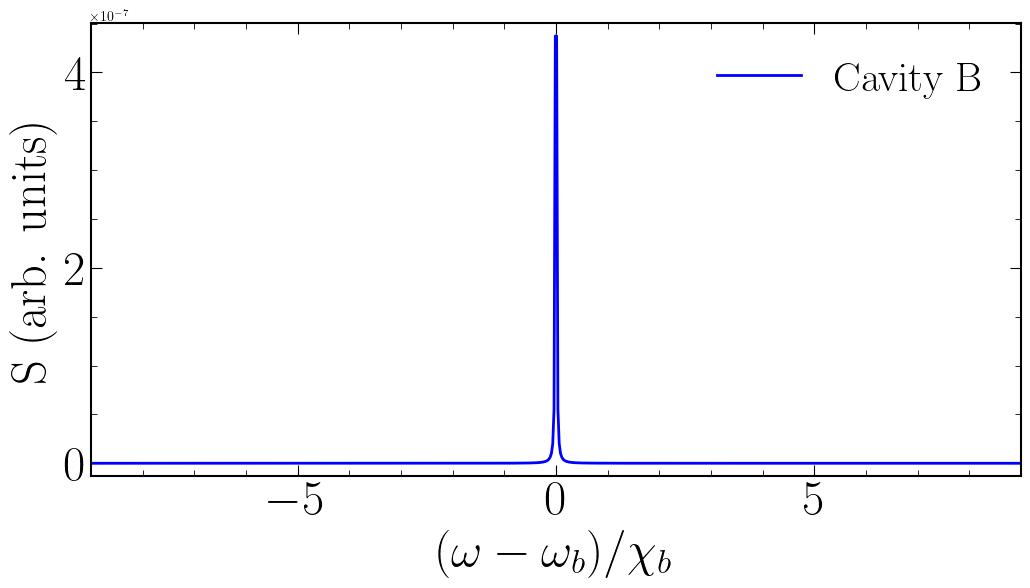

In [361]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist2)/(chi_b), (abs(slist_3)),'b', label='Cavity B', lw=2.0)

axes.set_xlabel(r'$(\omega-\omega_b)/\chi_b$', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-9,9)
#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

In [362]:
rho_ss = steadystate(H,c_ops)

rhoA = ptrace(rho_ss,(0))
rhoB = ptrace(rho_ss,(1))
rhoQ = ptrace(rho_ss,(2))
rhoR = ptrace(rho_ss,(3))


In [367]:
a_ss = expect(a, rho_ss)

In [368]:
a_ss

0j

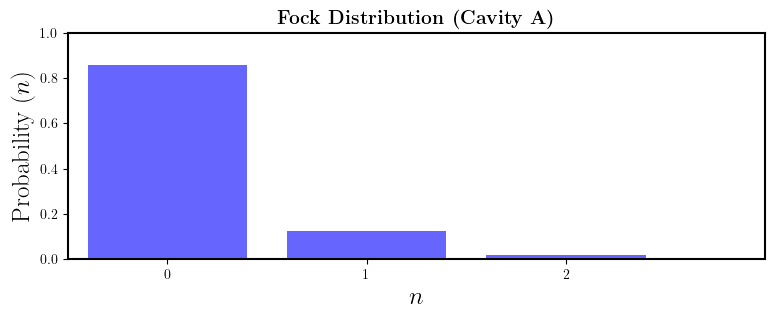

In [363]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, N), real(rhoA.diag()), color="blue", alpha=0.6)
axes.set_title("\\textbf{Fock Distribution (Cavity A)}",fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(arange(0, N))
axes.set_xlabel(r'$n$', fontsize=18)
axes.set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()

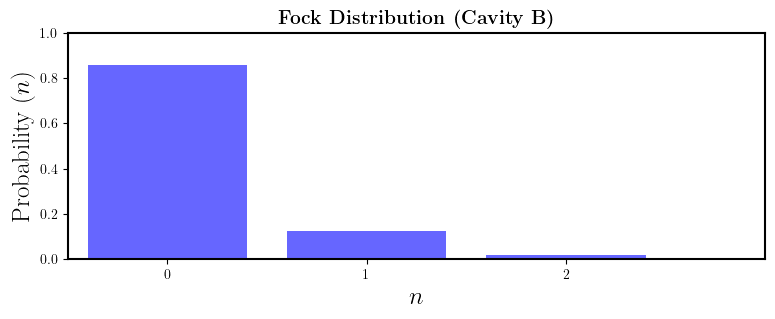

In [364]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, N), real(rhoB.diag()), color="blue", alpha=0.6)
axes.set_title("\\textbf{Fock Distribution (Cavity B)}",fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(arange(0, N))
axes.set_xlabel(r'$n$', fontsize=18)
axes.set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()

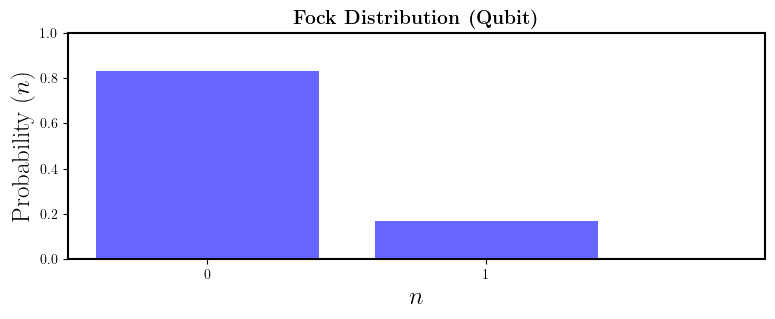

In [365]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, 2), real(rhoQ.diag()), color="blue", alpha=0.6)
axes.set_title("\\textbf{Fock Distribution (Qubit)}",fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, 2)
axes.set_xticks(arange(0, 2))
axes.set_xlabel(r'$n$', fontsize=18)
axes.set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()

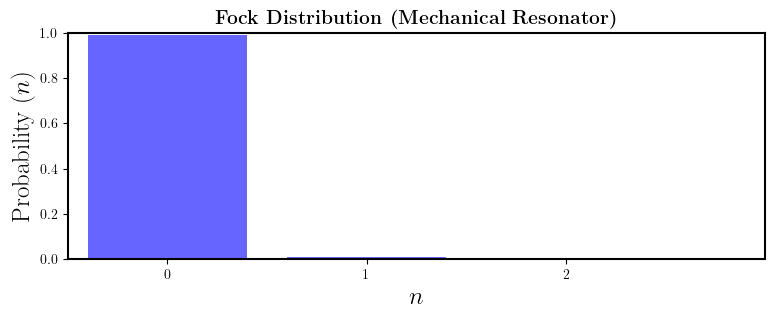

In [366]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, N), real(rhoR.diag()), color="blue", alpha=0.6)
axes.set_title("\\textbf{Fock Distribution (Mechanical Resonator)}",fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(arange(0, N))
axes.set_xlabel(r'$n$', fontsize=18)
axes.set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()


### Caso 2: Estado térmico, com MR

In [416]:
N = 3

##### Cavity A ######

wa = 2 * pi * 2.0 * 1e9

Ohm_a = wa
E_a = 2 * pi * 00 * 1e3    

kappa_a = 2 * pi * 100 * 1e3  

T_a = 0.05
w_th_a = (sc.k*T_a)/(sc.hbar)
n_th_a = n_thermal(wa, w_th_a)

###### Cavity B #####

wb = 2 * pi * 2.0 * 1e9

Ohm_b = wb
E_b = 2 * pi * 00 * 1e3   

kappa_b = 2 * pi * 100 * 1e3

T_b = 0.05
w_th_b = (sc.k*T_b)/(sc.hbar)
n_th_b = n_thermal(wb, w_th_b)


##### Qubit #####

wq = 2 * pi * 3.0 * 1e9

Ga = 2 * pi * 200 * 1e6
Gb = 2 * pi * 100 * 1e6

kappa_q = 2 * pi * 100 * 1e3

T_q = 0.09
w_th_q = (sc.k*T_q)/(sc.hbar)
n_th_q = n_thermal(wq, w_th_q)

##### Mechanical Resonator #####

wr = 2 * pi * 1.0 * 1e9

ga = 2 * pi * 50 * 1e6
gb = 2 * pi * 5 * 1e6

gamma = 10 * kappa_a  

T_r = 0.01
w_th_r = (sc.k*T_r)/(sc.hbar)
n_th_r = n_thermal(wr, w_th_r)


############################
(n_th_a, n_th_b, n_th_q, n_th_r)


(0.1718539759369543,
 0.1718539759369543,
 0.25305033913702896,
 0.008304373364239451)

In [425]:
a.expm()

Quantum object: dims = [[3, 3, 2, 3], [3, 3, 2, 3]], shape = (54, 54), type = oper, isherm = False
Qobj data =
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]

In [423]:
a

Quantum object: dims = [[3, 3, 2, 3], [3, 3, 2, 3]], shape = (54, 54), type = oper, isherm = False
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [420]:
n_th_q = n_thermal(wq,((sc.k*T_q)/(sc.hbar)))
n_th_q

0.25305033913702896

In [370]:
delta = abs(wa - wq)

delta/(2*pi*1e6), Ga/(2*pi*1e6)

(999.9999999999998, 200.00000000000003)

In [371]:
delta = abs(wb - wq)

delta/(2*pi*1e6), Gb/(2*pi*1e6)

(999.9999999999998, 100.00000000000001)

In [372]:
chi_a = Ga**2/(wq-wa)
chi_b = Gb**2/(wq-wb)

(chi_a/(2*pi*1e6),chi_b/(2*pi*1e6))

(40.00000000000002, 10.000000000000005)

In [373]:
# Operator definitions
a = tensor(destroy(N), qeye(N), qeye(2), qeye(N))
b = tensor(qeye(N), destroy(N), qeye(2), qeye(N))
r = tensor(qeye(N), qeye(N), qeye(2), destroy(N))
sm = tensor(qeye(N), qeye(N), destroy(2), qeye(N))
sz = tensor(qeye(N), qeye(N), sigmaz(), qeye(N))
sx = tensor(qeye(N), qeye(N), sigmax(), qeye(N))
I = tensor(qeye(N), qeye(N), qeye(2), qeye(N))

Na = a.dag() * a
Nb = b.dag() * b
Nq = sm.dag() * sm
Nr = r.dag() * r
Xa = a.dag() + a
Xb = b.dag() + b
Xq = sm.dag() + sm
Xr = r.dag() + r

In [374]:
Ha = (wa-Ohm_a) * Na
Hb = (wb-Ohm_b) * Nb
Hr = wr * Nr
Hint_a = -ga * Na * Xr
Hint_b = -gb * Nb * Xr
Hdrive_a = E_a * Xa
Hdrive_b = E_b * Xb
Hq = 0.5 * (wq) * sz
#Hqa = Ga * (a * sm.dag() + a.dag() * sm)
#Hqb = Gb * (b * sm.dag() + b.dag() * sm)
Hqa = (Ga**2/(wq-wa)) * Na * sz 
Hqb = (Gb**2/(wq-wb)) * Nb * sz 
        
H = Ha + Hb + Hr + Hint_a + Hint_b + Hdrive_a + Hdrive_b + Hq + Hqa + Hqb

In [375]:
# collapse operators
c_ops = []

# Relaxations, temperature = 0 or >0

# cavity-a relaxation
rate = kappa_a * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(sqrt(rate) * a)
    
# cavity-b relaxation
rate = kappa_b * (1 + n_th_b)
if rate > 0.0:
    c_ops.append(sqrt(rate) * b)
    
# mechanical oscillator relaxation
rate = gamma * (1 + n_th_r)
if rate > 0.0:
    c_ops.append(sqrt(rate) * r)

# qubit dissipation
rate = kappa_q * (1 + n_th_q)
if rate > 0.0:
    c_ops.append(sqrt(rate) * sm)
    
# Excitations, only temperature > 0  

rate = kappa_a * n_th_a
if rate > 0.0:
    c_ops.append(sqrt(rate) * a.dag())

rate = kappa_b * n_th_b
if rate > 0.0:
    c_ops.append(sqrt(rate) * b.dag())

rate = kappa_q * n_th_q
if rate > 0.0:
    c_ops.append(sqrt(rate) * sm.dag())

# mechanical oscillator excitation    
rate = gamma * n_th_r
if rate > 0.0:
    c_ops.append(sqrt(rate) * r.dag())

In [376]:
w_0 = 2 * pi * 2 * 1e9
w_f = 2 * pi * 4 * 1e9

wlist = linspace(w_0,w_f,5000)

slist = spectrum(H,wlist,c_ops,sx,sx)

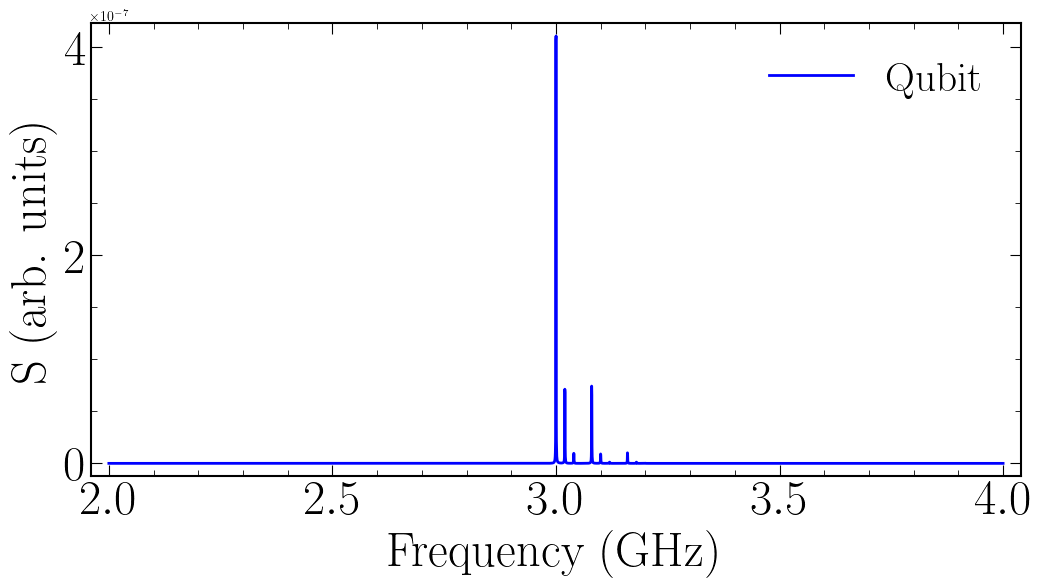

In [377]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot(wlist/(2*pi*1e9), (abs(slist)),'b', label='Qubit', lw=2.0)

axes.set_xlabel(r'Frequency (GHz)', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=0,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

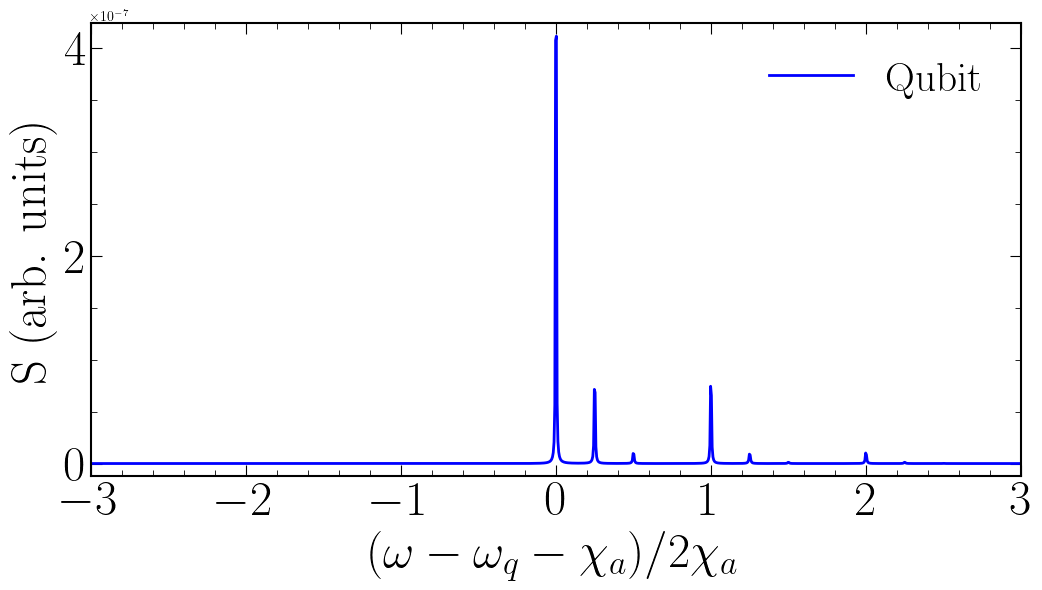

In [378]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist-wq)/(2*chi_a), (abs(slist)),'b', label='Qubit', lw=2.0)

axes.set_xlabel(r'$(\omega - \omega_q - \chi_a)/2\chi_a$', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-3,3)
#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

In [379]:
w_0_2 = 2 * pi * -1 * 1e9
w_f_2 = 2 * pi * 1 * 1e9

wlist2 = linspace(w_0_2,w_f_2,8000)

slist_2 = spectrum(H,wlist2,c_ops,a.dag(),a)

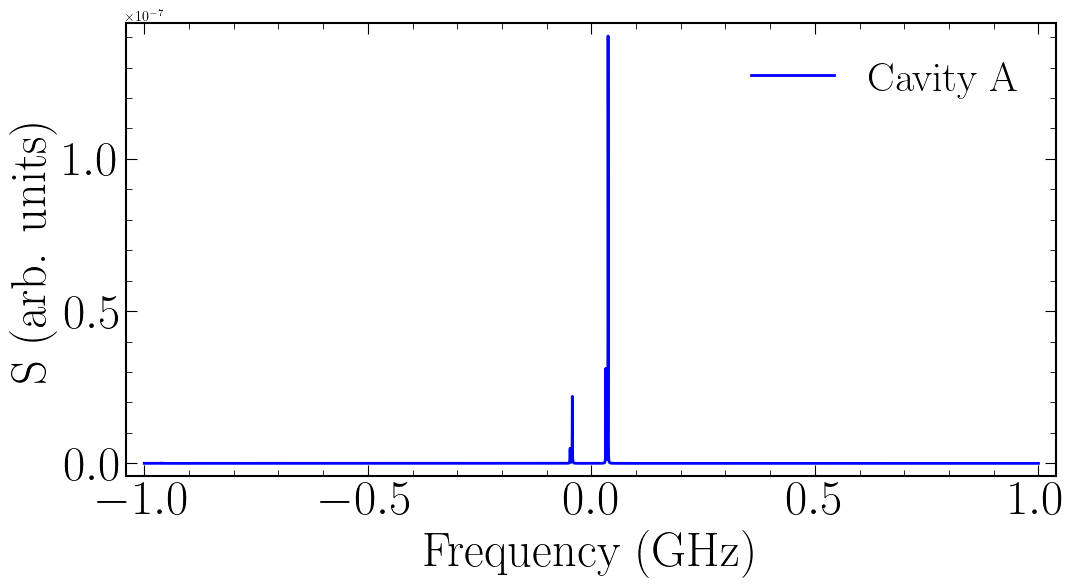

In [380]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist2)/(2*pi*1e9), (abs(slist_2)),'b', label='Cavity A', lw=2.0)

axes.set_xlabel(r'Frequency (GHz)', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

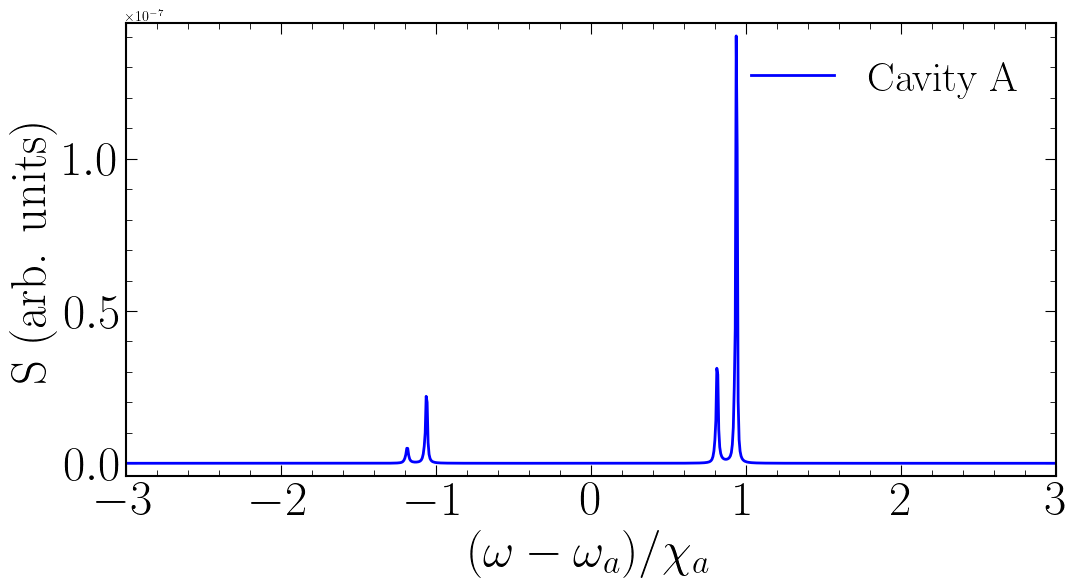

In [381]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist2)/(chi_a), (abs(slist_2)),'b', label='Cavity A', lw=2.0)

axes.set_xlabel(r'$(\omega-\omega_a)/\chi_a$', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-3,3)
#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

In [382]:
slist_3 = spectrum(H,wlist2,c_ops,b.dag(),b)

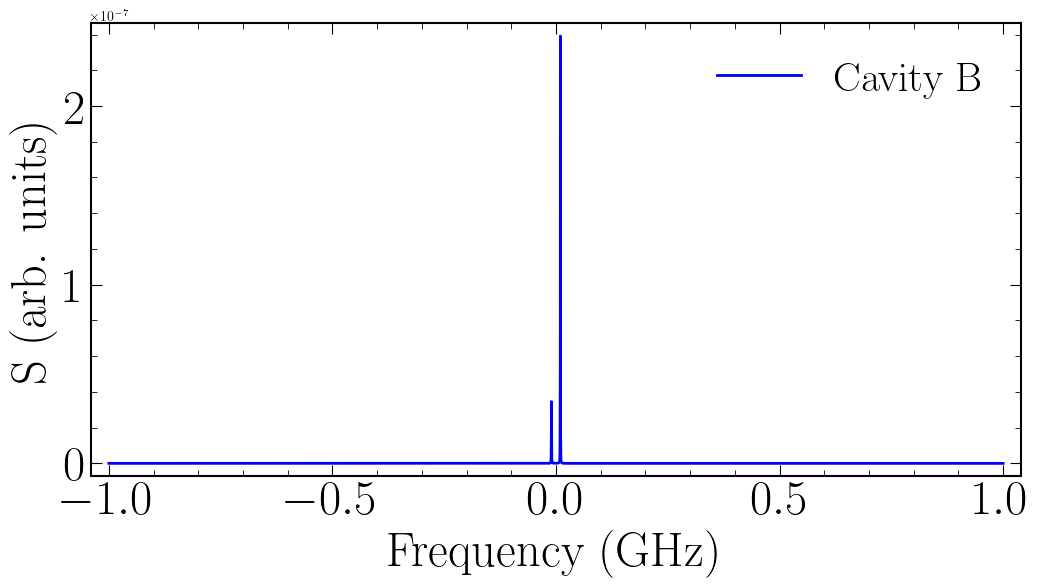

In [383]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist2)/(2*pi*1e9), (abs(slist_3)),'b', label='Cavity B', lw=2.0)

axes.set_xlabel(r'Frequency (GHz)', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

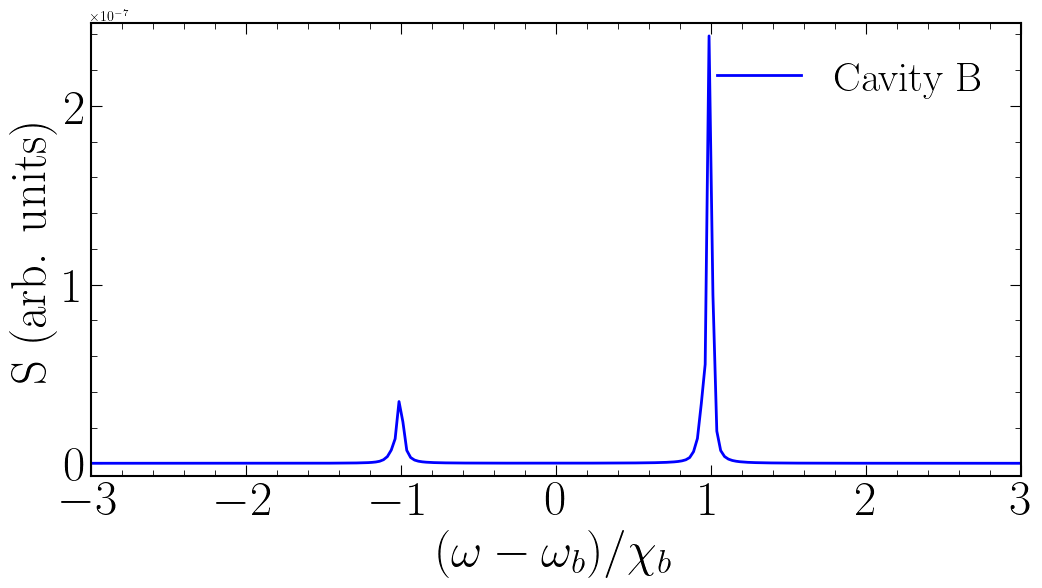

In [384]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist2)/(chi_b), (abs(slist_3)),'b', label='Cavity B', lw=2.0)

axes.set_xlabel(r'$(\omega-\omega_b)/\chi_b$', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-3,3)
#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

In [385]:
rho_ss = steadystate(H,c_ops)

rhoA = ptrace(rho_ss,(0))
rhoB = ptrace(rho_ss,(1))
rhoQ = ptrace(rho_ss,(2))
rhoR = ptrace(rho_ss,(3))


In [386]:
a_ss = expect(a, rho_ss)
a_ss

0j

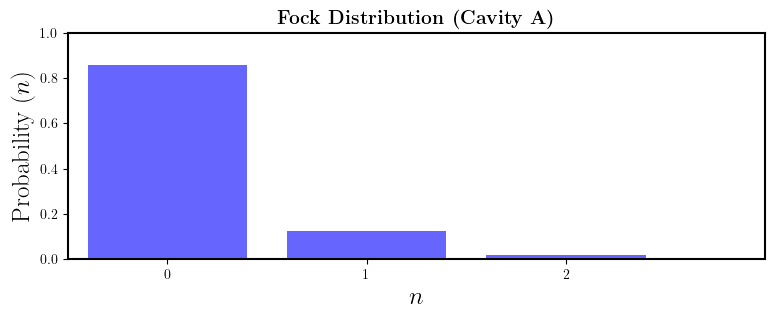

In [185]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, N), real(rhoA.diag()), color="blue", alpha=0.6)
axes.set_title("\\textbf{Fock Distribution (Cavity A)}",fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(arange(0, N))
axes.set_xlabel(r'$n$', fontsize=18)
axes.set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()

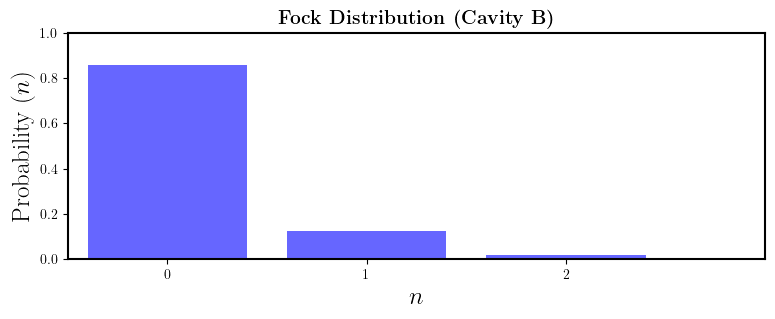

In [186]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, N), real(rhoB.diag()), color="blue", alpha=0.6)
axes.set_title("\\textbf{Fock Distribution (Cavity B)}",fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(arange(0, N))
axes.set_xlabel(r'$n$', fontsize=18)
axes.set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()

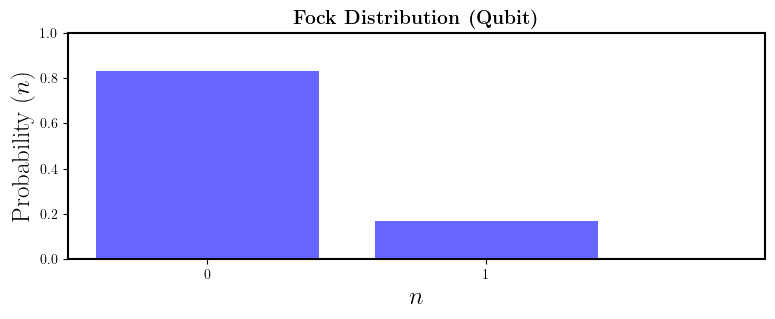

In [187]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, 2), real(rhoQ.diag()), color="blue", alpha=0.6)
axes.set_title("\\textbf{Fock Distribution (Qubit)}",fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, 2)
axes.set_xticks(arange(0, 2))
axes.set_xlabel(r'$n$', fontsize=18)
axes.set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()

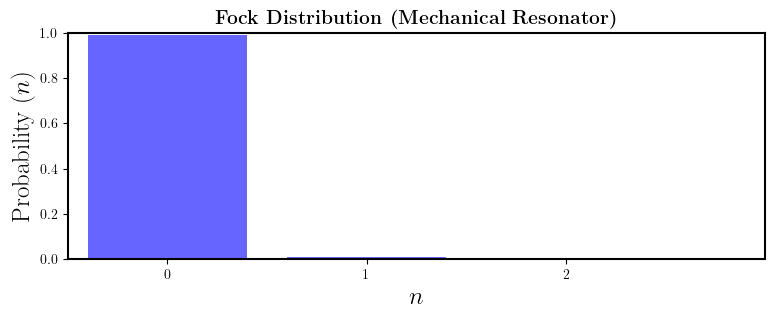

In [188]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, N), real(rhoR.diag()), color="blue", alpha=0.6)
axes.set_title("\\textbf{Fock Distribution (Mechanical Resonator)}",fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(arange(0, N))
axes.set_xlabel(r'$n$', fontsize=18)
axes.set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()


### Caso 3: Drive externo, sem MR

In [387]:
N = 3

##### Cavity A ######

wa = 2 * pi * 2.0 * 1e9

Ohm_a = wa
E_a = 2 * pi * 1 * 1e6    

kappa_a = 2 * pi * 100 * 1e3  

T_a = 0
w_th_a = (sc.k*T_a)/(sc.hbar)
n_th_a = n_thermal(wa, w_th_a)

###### Cavity B #####

wb = 2 * pi * 2.0 * 1e9

Ohm_b = wb
E_b = 2 * pi * 1 * 1e6   

kappa_b = 2 * pi * 100 * 1e3

T_b = 0
w_th_b = (sc.k*T_b)/(sc.hbar)
n_th_b = n_thermal(wb, w_th_b)


##### Qubit #####

wq = 2 * pi * 3.0 * 1e9

Ga = 2 * pi * 200 * 1e6
Gb = 2 * pi * 100 * 1e6

kappa_q = 2 * pi * 100 * 1e3

T_q = 0.09
w_th_q = (sc.k*T_q)/(sc.hbar)
n_th_q = n_thermal(wq, w_th_q)

##### Mechanical Resonator #####

wr = 2 * pi * 1.0 * 1e9

ga = 2 * pi * 0 * 1e6
gb = 2 * pi * 0 * 1e6

gamma = 10 * kappa_a  

T_r = 0.01
w_th_r = (sc.k*T_r)/(sc.hbar)
n_th_r = n_thermal(wr, w_th_r)


############################
(n_th_a, n_th_b, n_th_q, n_th_r)


(0.0, 0.0, 0.25305033913702896, 0.008304373364239451)

In [388]:
delta = abs(wa - wq)

delta/(2*pi*1e6), Ga/(2*pi*1e6)

(999.9999999999998, 200.00000000000003)

In [389]:
delta = abs(wb - wq)

delta/(2*pi*1e6), Gb/(2*pi*1e6)

(999.9999999999998, 100.00000000000001)

In [390]:
chi_a = Ga**2/(wq-wa)
chi_b = Gb**2/(wq-wb)

(chi_a/(2*pi*1e6),chi_b/(2*pi*1e6))

(40.00000000000002, 10.000000000000005)

In [391]:
# Operator definitions
a = tensor(destroy(N), qeye(N), qeye(2), qeye(N))
b = tensor(qeye(N), destroy(N), qeye(2), qeye(N))
r = tensor(qeye(N), qeye(N), qeye(2), destroy(N))
sm = tensor(qeye(N), qeye(N), destroy(2), qeye(N))
sz = tensor(qeye(N), qeye(N), sigmaz(), qeye(N))
sx = tensor(qeye(N), qeye(N), sigmax(), qeye(N))
I = tensor(qeye(N), qeye(N), qeye(2), qeye(N))

Na = a.dag() * a
Nb = b.dag() * b
Nq = sm.dag() * sm
Nr = r.dag() * r
Xa = a.dag() + a
Xb = b.dag() + b
Xq = sm.dag() + sm
Xr = r.dag() + r

In [392]:
Ha = (wa-Ohm_a) * Na
Hb = (wb-Ohm_b) * Nb
Hr = wr * Nr
Hint_a = -ga * Na * Xr
Hint_b = -gb * Nb * Xr
Hdrive_a = E_a * Xa
Hdrive_b = E_b * Xb
Hq = 0.5 * (wq) * sz
#Hqa = Ga * (a * sm.dag() + a.dag() * sm)
#Hqb = Gb * (b * sm.dag() + b.dag() * sm)
Hqa = (Ga**2/(wq-wa)) * Na * sz 
Hqb = (Gb**2/(wq-wb)) * Nb * sz 
        
H = Ha + Hb + Hr + Hint_a + Hint_b + Hdrive_a + Hdrive_b + Hq + Hqa + Hqb

In [393]:
# collapse operators
c_ops = []

# Relaxations, temperature = 0 or >0

# cavity-a relaxation
rate = kappa_a * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(sqrt(rate) * a)
    
# cavity-b relaxation
rate = kappa_b * (1 + n_th_b)
if rate > 0.0:
    c_ops.append(sqrt(rate) * b)
    
# mechanical oscillator relaxation
rate = gamma * (1 + n_th_r)
if rate > 0.0:
    c_ops.append(sqrt(rate) * r)

# qubit dissipation
rate = kappa_q * (1 + n_th_q)
if rate > 0.0:
    c_ops.append(sqrt(rate) * sm)
    
# Excitations, only temperature > 0  

rate = kappa_a * n_th_a
if rate > 0.0:
    c_ops.append(sqrt(rate) * a.dag())

rate = kappa_b * n_th_b
if rate > 0.0:
    c_ops.append(sqrt(rate) * b.dag())

rate = kappa_q * n_th_q
if rate > 0.0:
    c_ops.append(sqrt(rate) * sm.dag())

# mechanical oscillator excitation    
rate = gamma * n_th_r
if rate > 0.0:
    c_ops.append(sqrt(rate) * r.dag())

In [394]:
w_0 = 2 * pi * 2 * 1e9
w_f = 2 * pi * 4 * 1e9

wlist = linspace(w_0,w_f,5000)

slist = spectrum(H,wlist,c_ops,sx,sx)

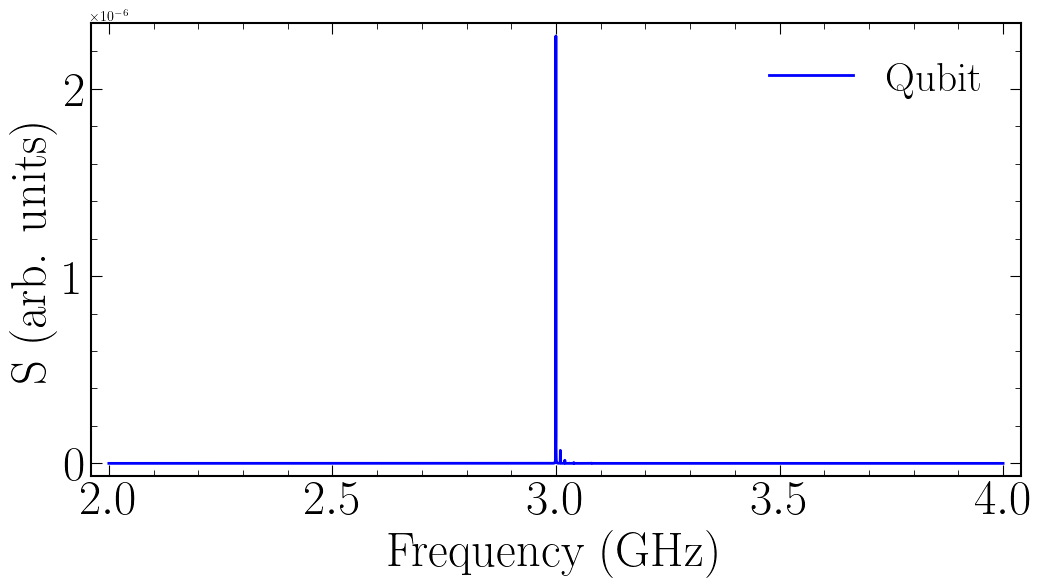

In [395]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot(wlist/(2*pi*1e9), (abs(slist)),'b', label='Qubit', lw=2.0)

axes.set_xlabel(r'Frequency (GHz)', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=0,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

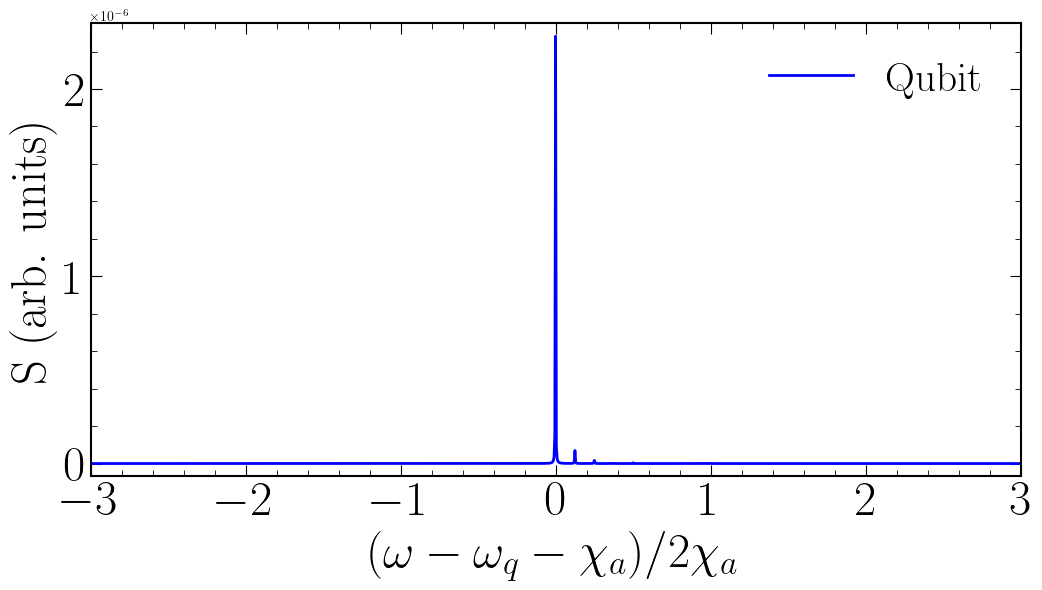

In [396]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist-wq)/(2*chi_a), (abs(slist)),'b', label='Qubit', lw=2.0)

axes.set_xlabel(r'$(\omega - \omega_q - \chi_a)/2\chi_a$', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-3,3)
#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

In [397]:
w_0_2 = 2 * pi * -1 * 1e9
w_f_2 = 2 * pi * 1 * 1e9

wlist2 = linspace(w_0_2,w_f_2,8000)

slist_2 = spectrum(H,wlist2,c_ops,a.dag(),a)

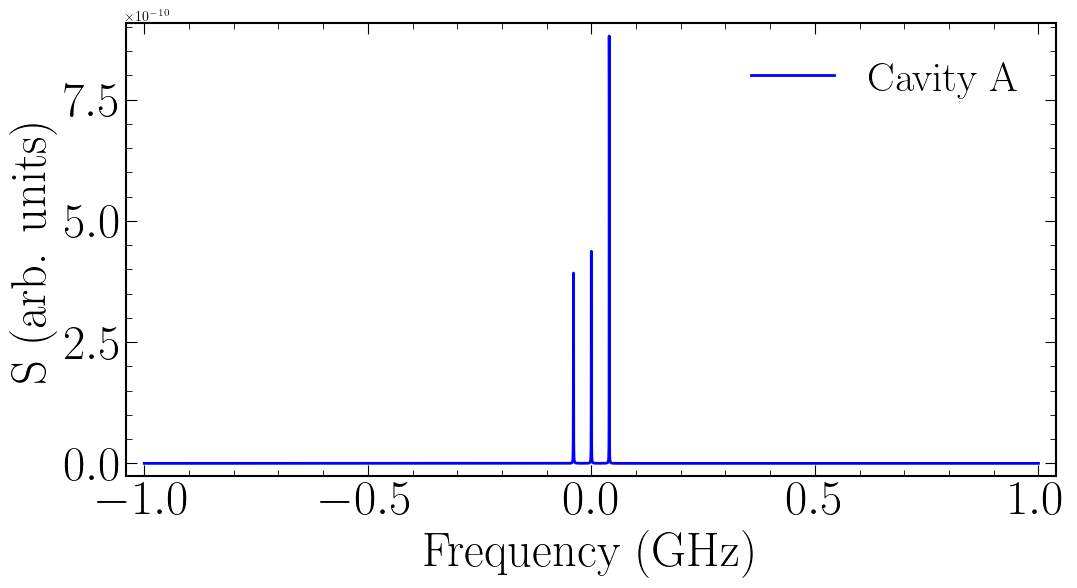

In [398]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist2)/(2*pi*1e9), (abs(slist_2)),'b', label='Cavity A', lw=2.0)

axes.set_xlabel(r'Frequency (GHz)', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

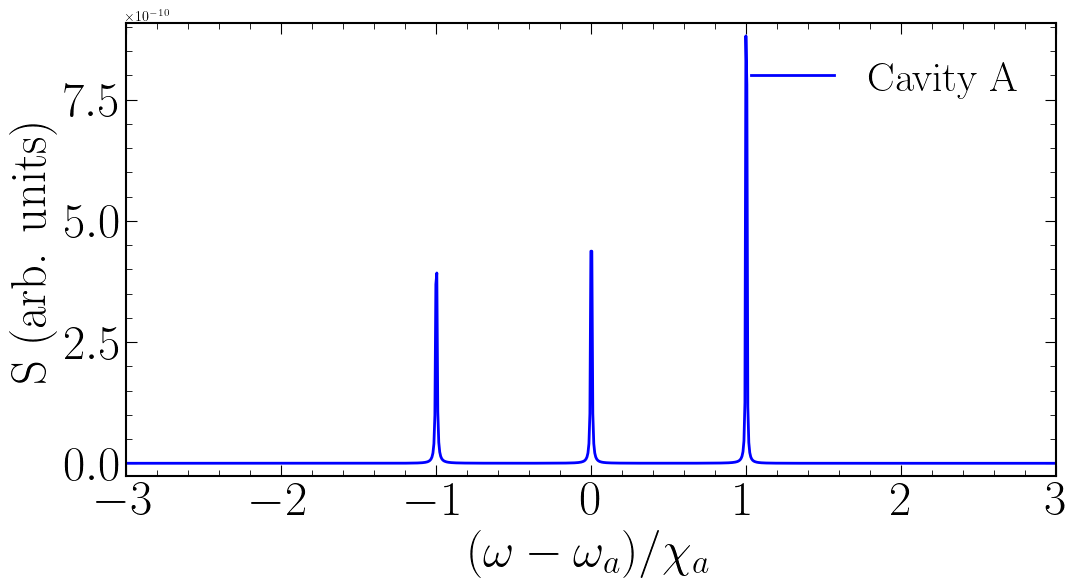

In [399]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist2)/(chi_a), (abs(slist_2)),'b', label='Cavity A', lw=2.0)

axes.set_xlabel(r'$(\omega-\omega_a)/\chi_a$', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-3,3)
#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

In [400]:
slist_3 = spectrum(H,wlist2,c_ops,b.dag(),b)

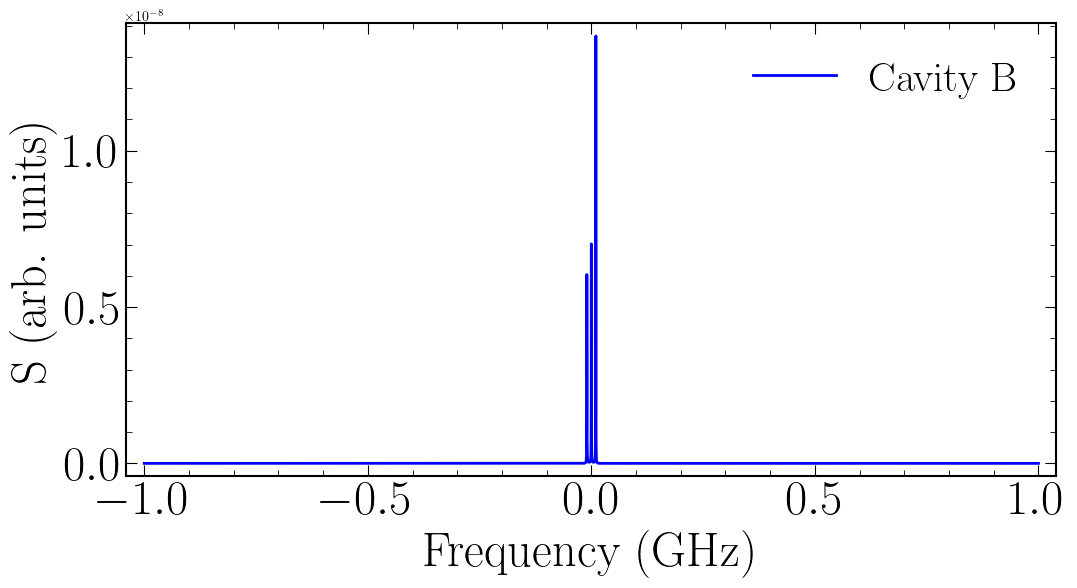

In [401]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist2)/(2*pi*1e9), (abs(slist_3)),'b', label='Cavity B', lw=2.0)

axes.set_xlabel(r'Frequency (GHz)', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

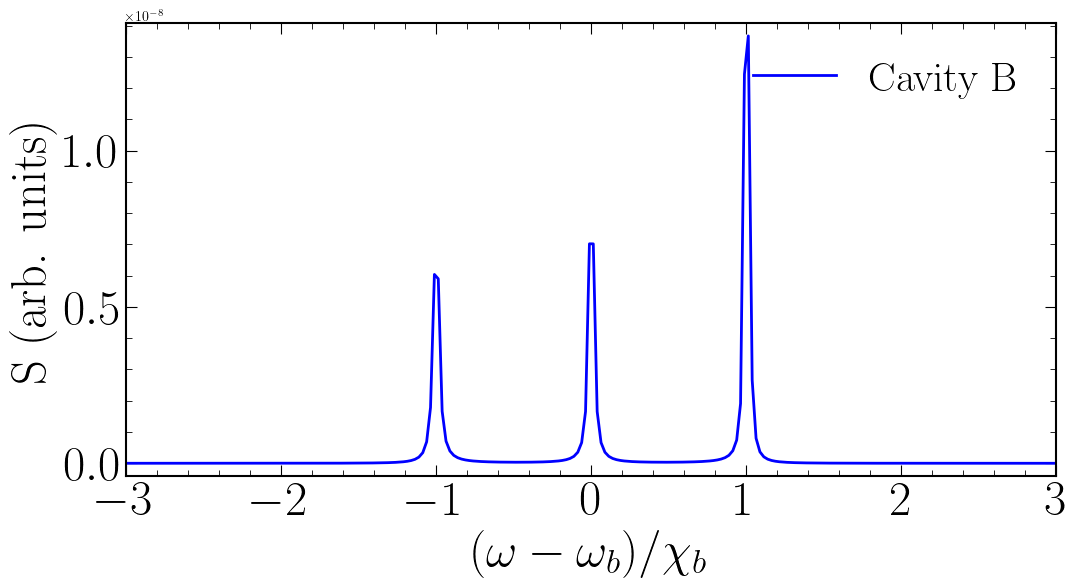

In [402]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist2)/(chi_b), (abs(slist_3)),'b', label='Cavity B', lw=2.0)

axes.set_xlabel(r'$(\omega-\omega_b)/\chi_b$', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-3,3)
#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

In [403]:
rho_ss = steadystate(H,c_ops)

rhoA = ptrace(rho_ss,(0))
rhoB = ptrace(rho_ss,(1))
rhoQ = ptrace(rho_ss,(2))
rhoR = ptrace(rho_ss,(3))


In [410]:
a_ss = expect(a, rho_ss)
abs(a_ss)

0.016599357563490163

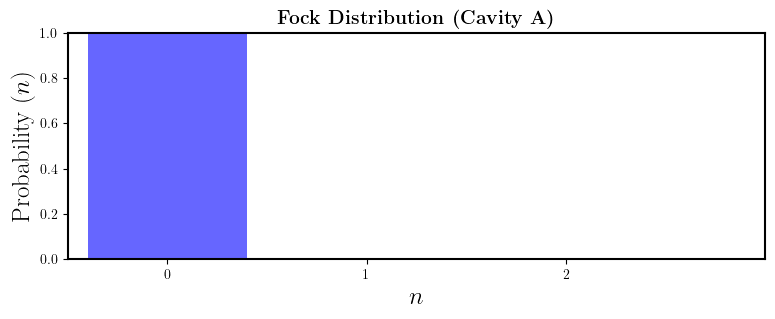

In [404]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, N), real(rhoA.diag()), color="blue", alpha=0.6)
axes.set_title("\\textbf{Fock Distribution (Cavity A)}",fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(arange(0, N))
axes.set_xlabel(r'$n$', fontsize=18)
axes.set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()

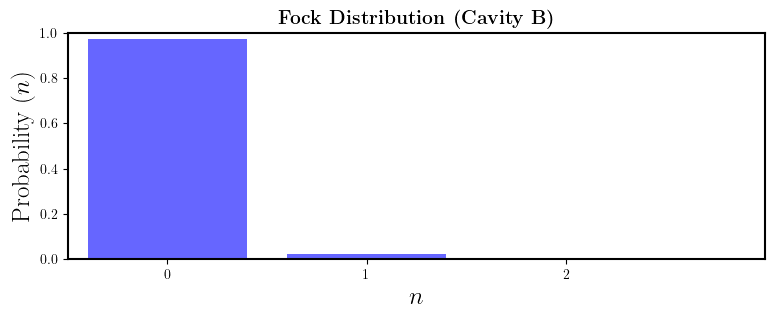

In [405]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, N), real(rhoB.diag()), color="blue", alpha=0.6)
axes.set_title("\\textbf{Fock Distribution (Cavity B)}",fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(arange(0, N))
axes.set_xlabel(r'$n$', fontsize=18)
axes.set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()

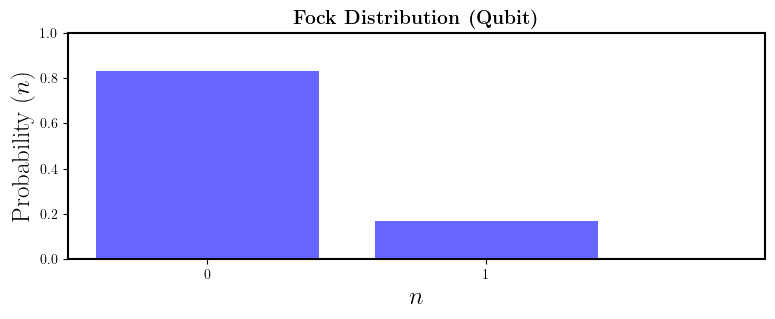

In [406]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, 2), real(rhoQ.diag()), color="blue", alpha=0.6)
axes.set_title("\\textbf{Fock Distribution (Qubit)}",fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, 2)
axes.set_xticks(arange(0, 2))
axes.set_xlabel(r'$n$', fontsize=18)
axes.set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()

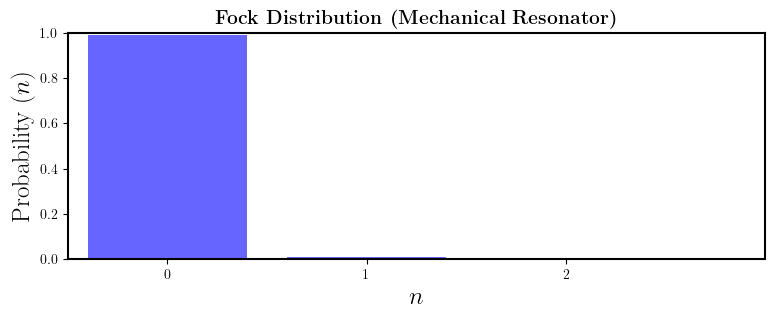

In [407]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, N), real(rhoR.diag()), color="blue", alpha=0.6)
axes.set_title("\\textbf{Fock Distribution (Mechanical Resonator)}",fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(arange(0, N))
axes.set_xlabel(r'$n$', fontsize=18)
axes.set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()


### Caso 4: Drive externo, com MR

In [211]:
N = 3

##### Cavity A ######

wa = 2 * pi * 2.0 * 1e9

Ohm_a = wa
E_a = 2 * pi * 200 * 1e3    

kappa_a = 2 * pi * 100 * 1e3  

T_a = 0
w_th_a = (sc.k*T_a)/(sc.hbar)
n_th_a = n_thermal(wa, w_th_a)

###### Cavity B #####

wb = 2 * pi * 2.0 * 1e9

Ohm_b = wb
E_b = 2 * pi * 200 * 1e3   

kappa_b = 2 * pi * 100 * 1e3

T_b = 0
w_th_b = (sc.k*T_b)/(sc.hbar)
n_th_b = n_thermal(wb, w_th_b)


##### Qubit #####

wq = 2 * pi * 3.0 * 1e9

Ga = 2 * pi * 200 * 1e6
Gb = 2 * pi * 100 * 1e6

kappa_q = 2 * pi * 100 * 1e3

T_q = 0.09
w_th_q = (sc.k*T_q)/(sc.hbar)
n_th_q = n_thermal(wq, w_th_q)

##### Mechanical Resonator #####

wr = 2 * pi * 1.0 * 1e9

ga = 2 * pi * 50 * 1e6
gb = 2 * pi * 5 * 1e6

gamma = 10 * kappa_a  

T_r = 0.01
w_th_r = (sc.k*T_r)/(sc.hbar)
n_th_r = n_thermal(wr, w_th_r)


############################
(n_th_a, n_th_b, n_th_q, n_th_r)


(0.0, 0.0, 0.25305033913702896, 0.008304373364239451)

In [212]:
delta = abs(wa - wq)

delta/(2*pi*1e6), Ga/(2*pi*1e6)

(999.9999999999998, 200.00000000000003)

In [213]:
delta = abs(wb - wq)

delta/(2*pi*1e6), Gb/(2*pi*1e6)

(999.9999999999998, 100.00000000000001)

In [214]:
chi_a = Ga**2/(wq-wa)
chi_b = Gb**2/(wq-wb)

(chi_a/(2*pi*1e6),chi_b/(2*pi*1e6))

(40.00000000000002, 10.000000000000005)

In [215]:
# Operator definitions
a = tensor(destroy(N), qeye(N), qeye(2), qeye(N))
b = tensor(qeye(N), destroy(N), qeye(2), qeye(N))
r = tensor(qeye(N), qeye(N), qeye(2), destroy(N))
sm = tensor(qeye(N), qeye(N), destroy(2), qeye(N))
sz = tensor(qeye(N), qeye(N), sigmaz(), qeye(N))
sx = tensor(qeye(N), qeye(N), sigmax(), qeye(N))
I = tensor(qeye(N), qeye(N), qeye(2), qeye(N))

Na = a.dag() * a
Nb = b.dag() * b
Nq = sm.dag() * sm
Nr = r.dag() * r
Xa = a.dag() + a
Xb = b.dag() + b
Xq = sm.dag() + sm
Xr = r.dag() + r

The Hamiltonian which describes a system of two cavity modes coupled a single mechancial mode and two level system (qubit) will be given by 

$$ \hat{H} = \hat{H}_0 + \hat{H}_\text{int} + \hat{H}_\text{drive}, $$

where the first term $\hat{H}_0$ corresponds to the free Hamiltonian of the system, which will be given by

$$\hat{H}_0 = \omega_r\hat{r}^\dagger\hat{r} + \Delta_a\,\hat{a}^\dagger \hat{a}  + \Delta_b\,\hat{b}^\dagger \hat{b} +  \frac{\omega_q}{2}\sigma_z ,$$

where $\Delta_k = \omega_k - \Omega_k$ is the detuning between the cavity modes and the driving field. The interaction between multiple parts of the system will be described by the second term $H_\text{int}$ which is given by

$$\hat{H}_\text{int} = - g_a\,\hat{a}^\dagger\hat{a}(\hat{r}^\dagger+\hat{r}) - g_b\,\hat{b}^\dagger\hat{b}(\hat{r}^\dagger+\hat{r}) + \left(\frac{{G_a}^2}{\omega_q - \omega_a}\right)\, (\hat{a}^\dagger\hat{a} + 1/2)\sigma_z +  \left(\frac{{G_b}^2}{\omega_q - \omega_b}\right) \, (\hat{b}^\dagger\hat{b}+ 1/2)\,\sigma_z,$$

where we can define the ratio $\chi_k \equiv \frac{{G_k}^2}{\omega_q - \omega_k}$. Finally, the cavities will be driven by an external field described by the last term $H_\text{drive}$ given by

$$\hat{H}_\text{drive} =  E_a \left(\hat{a}^\dagger + \hat{a}\right)  +  E_b \left(\hat{b}^\dagger + \hat{b}\right).$$




In [216]:
Ha = (wa-Ohm_a) * Na
Hb = (wb-Ohm_b) * Nb
Hr = wr * Nr
Hint_a = -ga * Na * Xr
Hint_b = -gb * Nb * Xr
Hdrive_a = E_a * Xa
Hdrive_b = E_b * Xb
Hq = 0.5 * (wq) * sz
#Hqa = Ga * (a * sm.dag() + a.dag() * sm)
#Hqb = Gb * (b * sm.dag() + b.dag() * sm)
Hqa = (Ga**2/(wq-wa)) * Na * sz 
Hqb = (Gb**2/(wq-wb)) * Nb * sz 
        
H = Ha + Hb + Hr + Hint_a + Hint_b + Hdrive_a + Hdrive_b + Hq + Hqa + Hqb

In [217]:
# collapse operators
c_ops = []

# Relaxations, temperature = 0 or >0

# cavity-a relaxation
rate = kappa_a * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(sqrt(rate) * a)
    
# cavity-b relaxation
rate = kappa_b * (1 + n_th_b)
if rate > 0.0:
    c_ops.append(sqrt(rate) * b)
    
# mechanical oscillator relaxation
rate = gamma * (1 + n_th_r)
if rate > 0.0:
    c_ops.append(sqrt(rate) * r)

# qubit dissipation
rate = kappa_q * (1 + n_th_q)
if rate > 0.0:
    c_ops.append(sqrt(rate) * sm)
    
# Excitations, only temperature > 0  

rate = kappa_a * n_th_a
if rate > 0.0:
    c_ops.append(sqrt(rate) * a.dag())

rate = kappa_b * n_th_b
if rate > 0.0:
    c_ops.append(sqrt(rate) * b.dag())

rate = kappa_q * n_th_q
if rate > 0.0:
    c_ops.append(sqrt(rate) * sm.dag())

# mechanical oscillator excitation    
rate = gamma * n_th_r
if rate > 0.0:
    c_ops.append(sqrt(rate) * r.dag())

In [218]:
w_0 = 2 * pi * 2 * 1e9
w_f = 2 * pi * 4 * 1e9

wlist = linspace(w_0,w_f,5000)

slist = spectrum(H,wlist,c_ops,sx,sx)

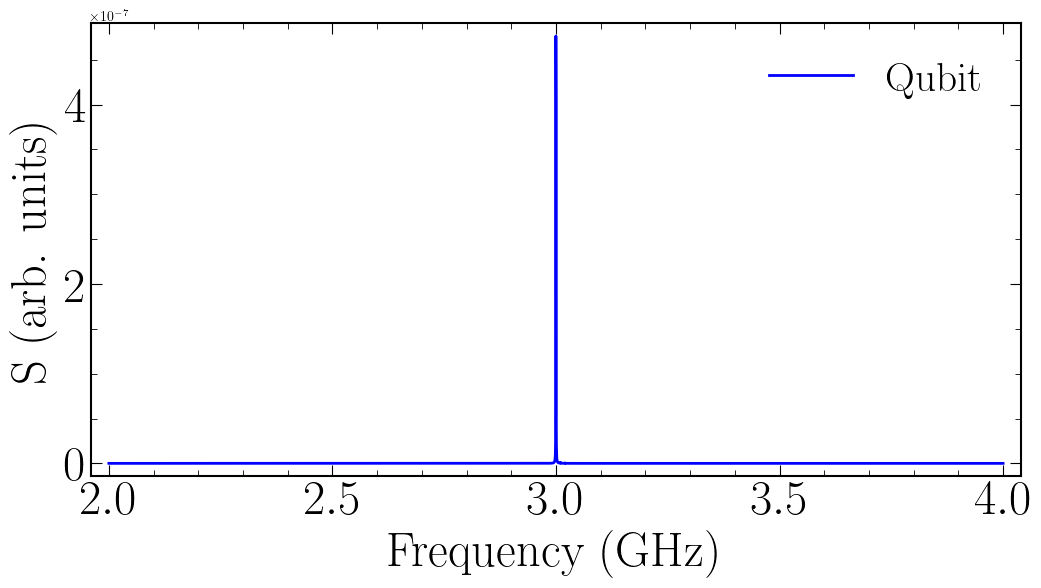

In [219]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot(wlist/(2*pi*1e9), (abs(slist)),'b', label='Qubit', lw=2.0)

axes.set_xlabel(r'Frequency (GHz)', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=0,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

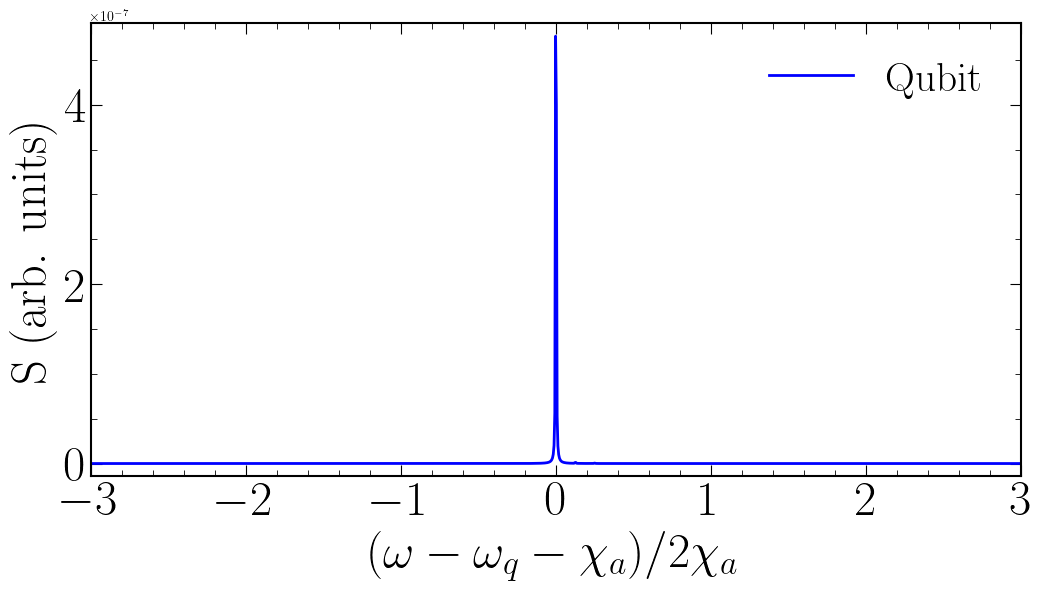

In [220]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist-wq)/(2*chi_a), (abs(slist)),'b', label='Qubit', lw=2.0)

axes.set_xlabel(r'$(\omega - \omega_q - \chi_a)/2\chi_a$', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-3,3)
#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

In [221]:
w_0_2 = 2 * pi * -1 * 1e9
w_f_2 = 2 * pi * 1 * 1e9

wlist2 = linspace(w_0_2,w_f_2,8000)

slist_2 = spectrum(H,wlist2,c_ops,a.dag(),a)

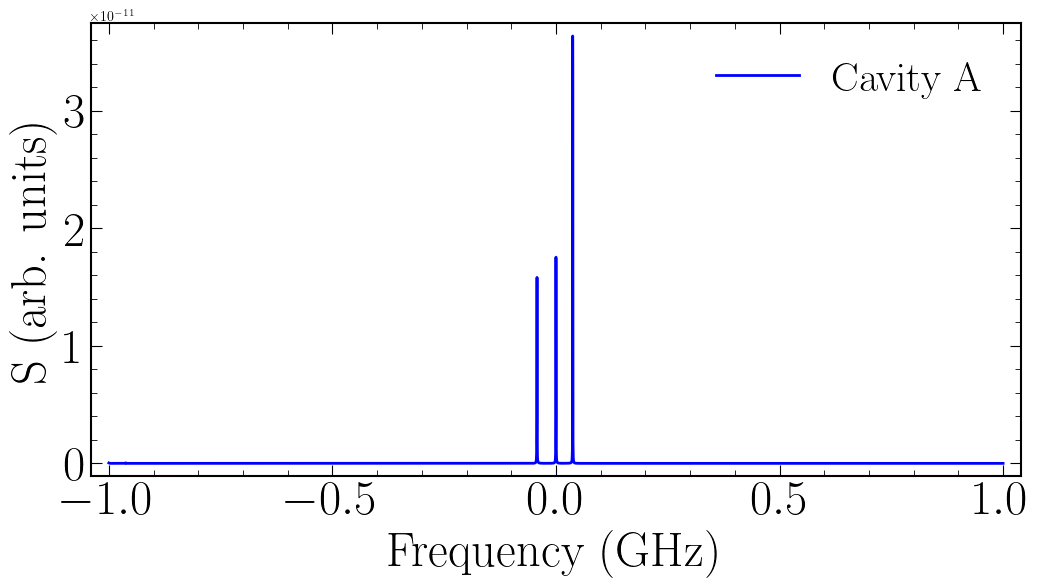

In [222]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist2)/(2*pi*1e9), (abs(slist_2)),'b', label='Cavity A', lw=2.0)

axes.set_xlabel(r'Frequency (GHz)', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

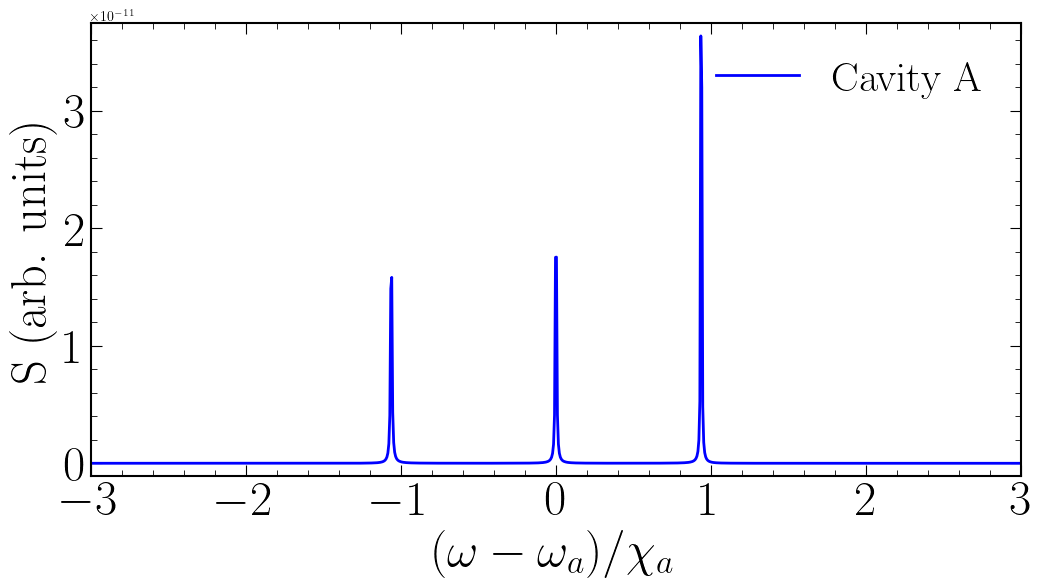

In [223]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist2)/(chi_a), (abs(slist_2)),'b', label='Cavity A', lw=2.0)

axes.set_xlabel(r'$(\omega-\omega_a)/\chi_a$', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-3,3)
#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

In [224]:
slist_3 = spectrum(H,wlist2,c_ops,b.dag(),b)

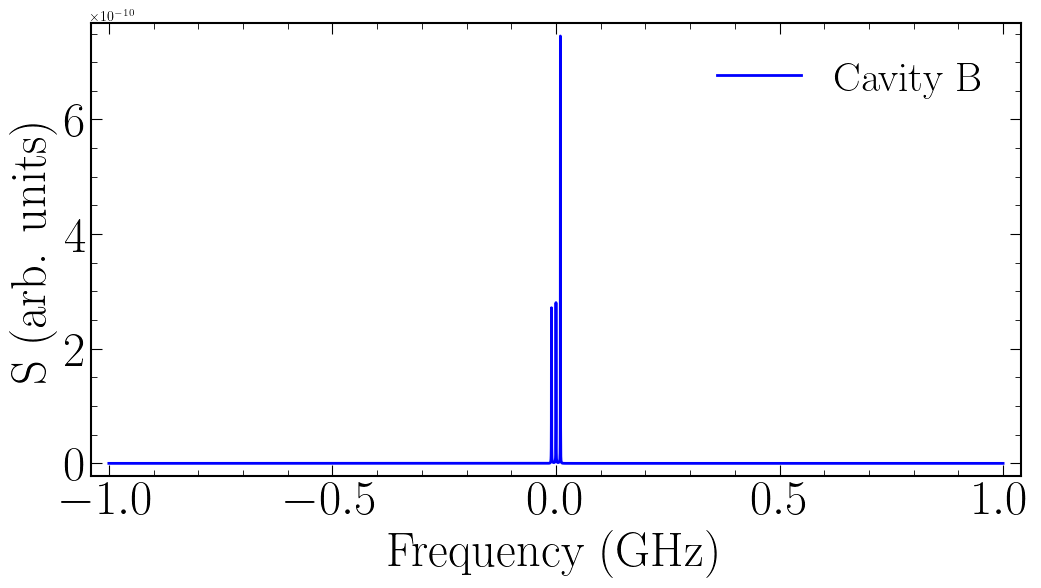

In [225]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist2)/(2*pi*1e9), (abs(slist_3)),'b', label='Cavity B', lw=2.0)

axes.set_xlabel(r'Frequency (GHz)', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

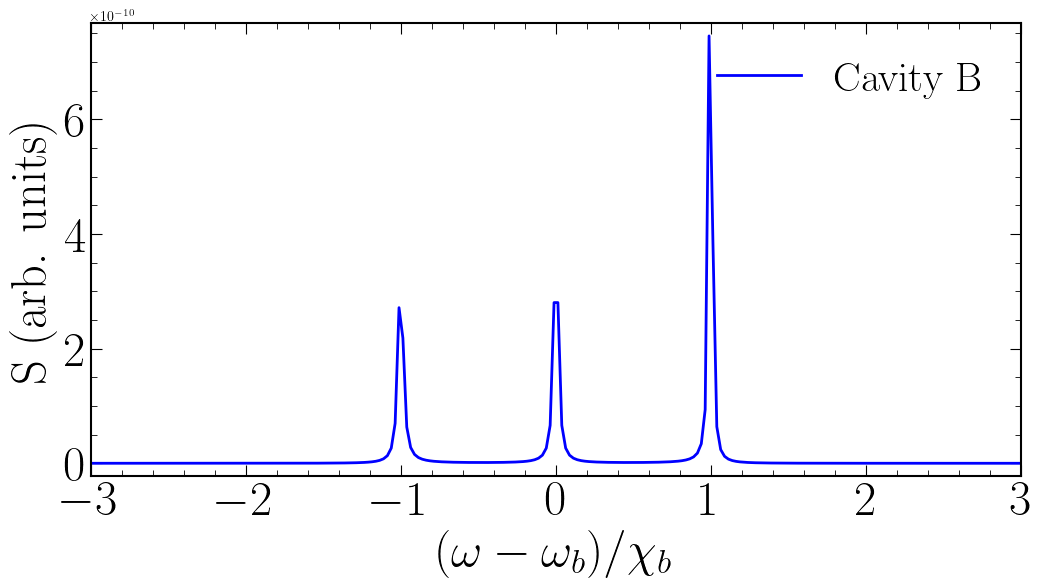

In [226]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.plot((wlist2)/(chi_b), (abs(slist_3)),'b', label='Cavity B', lw=2.0)

axes.set_xlabel(r'$(\omega-\omega_b)/\chi_b$', rotation=0, fontsize=35)
axes.set_ylabel(r'S (arb. units)', rotation=90, fontsize=35)

axes.tick_params(axis='both', which='major', length = 8, direction='in', labelsize=35)
axes.tick_params(axis='both', which='minor', length = 4, direction='in', labelsize=35)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-3,3)
#start, end = axes.get_ylim()
#axes.xaxis.set_ticks(arange(1, 4.1, 0.5))
#axes.yaxis.set_ticks(arange(start, end+1, 10))

axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.yaxis.set_minor_locator(AutoMinorLocator())

axes.legend(loc=1,fontsize=30,frameon=False)

axes.margins(x=0.02, y=0.03)

plt.show()

In [227]:
rho_ss = steadystate(H,c_ops)

rhoA = ptrace(rho_ss,(0))
rhoB = ptrace(rho_ss,(1))
rhoQ = ptrace(rho_ss,(2))
rhoR = ptrace(rho_ss,(3))


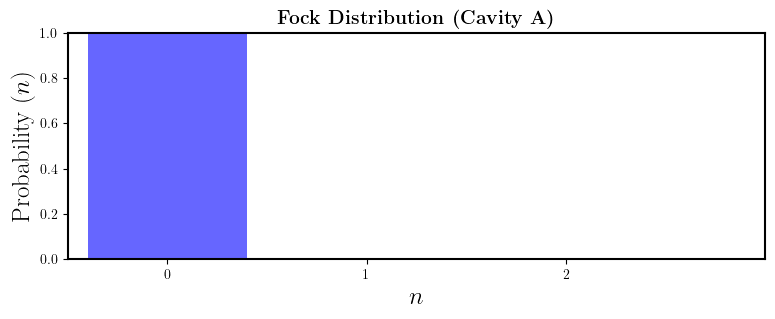

In [228]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, N), real(rhoA.diag()), color="blue", alpha=0.6)
axes.set_title("\\textbf{Fock Distribution (Cavity A)}",fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(arange(0, N))
axes.set_xlabel(r'$n$', fontsize=18)
axes.set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()

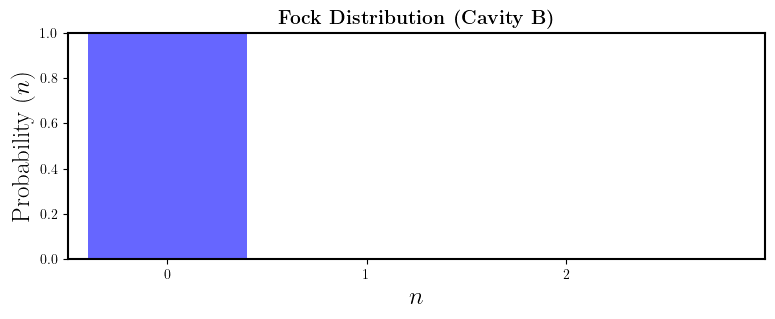

In [229]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, N), real(rhoB.diag()), color="blue", alpha=0.6)
axes.set_title("\\textbf{Fock Distribution (Cavity B)}",fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(arange(0, N))
axes.set_xlabel(r'$n$', fontsize=18)
axes.set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()

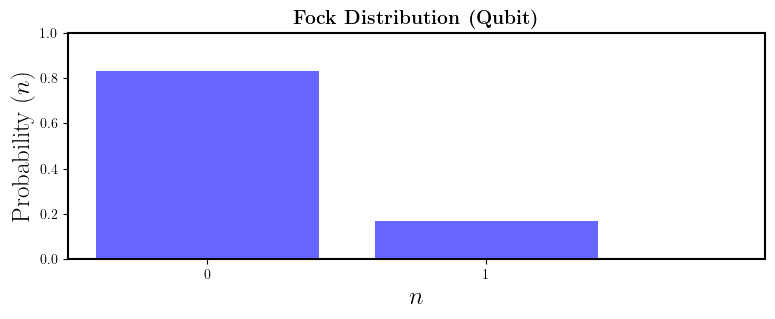

In [230]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, 2), real(rhoQ.diag()), color="blue", alpha=0.6)
axes.set_title("\\textbf{Fock Distribution (Qubit)}",fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, 2)
axes.set_xticks(arange(0, 2))
axes.set_xlabel(r'$n$', fontsize=18)
axes.set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()

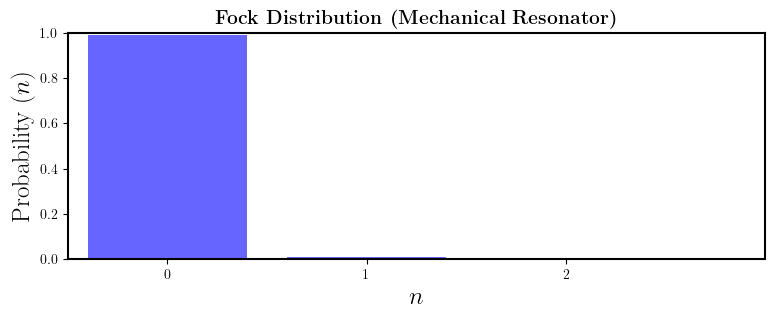

In [231]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(arange(0, N), real(rhoR.diag()), color="blue", alpha=0.6)
axes.set_title("\\textbf{Fock Distribution (Mechanical Resonator)}",fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(arange(0, N))
axes.set_xlabel(r'$n$', fontsize=18)
axes.set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()


### Caso 5